Here is a simpler example of the use of LIME for image classification by using Keras (v2 or greater)

In [2]:
import os
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
%matplotlib inline
import numpy as np

# from Desktop.lime import lime
print('Notebook run using keras:', keras.__version__)

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Notebook run using keras: 2.1.3


# Using Inception
Here we create a standard InceptionV3 pretrained model and use it on images by first preprocessing them with the preprocessing tools

In [3]:
inet_model = inc_net.InceptionV3()

In [4]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

## Let's see the top 5 prediction for some image

('n02133161', 'American_black_bear', 0.6371618)


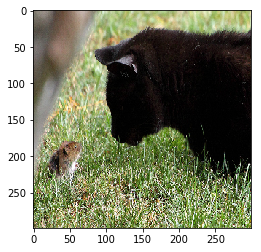

In [6]:
images = transform_img_fn([os.path.join('data','cat_mouse.jpg')])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = inet_model.predict(images)
for x in decode_predictions(preds, top=1)[0]:
    _id = str([x[0], x[1]])
    print(x)

(class, description, probability)

## Explanation
Now let's get an explanation

In [7]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

In [8]:
explainer = lime_image.LimeImageExplainer()

hide_color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels. Here, we set it to 0 (in the representation used by inception model, 0 means gray)

In [ ]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
b_explanation = explainer.explain_instance(images[0], inet_model.predict, top_labels=5, hide_color=0, num_samples=100, num_features=5, use_bandits=True)
print(b_explanation.top_labels)

In [9]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0], inet_model.predict, top_labels=5, hide_color=0, num_samples=1000, num_features=5)
print(explanation.top_labels)

[295, 224, 223, 106, 104]
CPU times: user 30.2 s, sys: 16.3 s, total: 46.5 s
Wall time: 43.8 s


In [48]:
from descartes import PolygonPatch
from shapely.geometry import Point
from shapely.geometry import MultiPoint
from matplotlib.patches import PathPatch

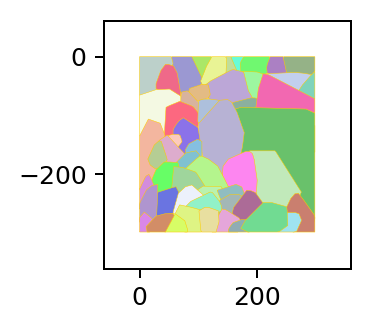

In [52]:
segments = explanation.segments
section_numbers = np.unique(segments)

polygons = []
for num in section_numbers:
    shape = np.where(segments == num)
    coords = list(zip(shape[1], shape[0] * -1))
    polygons.append(MultiPoint(coords).convex_hull)

# ---------------------------------------
# Create a matplotlib figure
fig = plt.figure(num=1, figsize=(10, 4), dpi=180)

# 1
# Create a subplot
ax = fig.add_subplot(221)

# minx, miny, maxx, maxy = float('inf'), float('inf'), float('-inf'), float('-inf')

for polygon in polygons:
    # Make the polygon into a patch and add it to the subplot
    c = (np.random.random((1, 3))*0.6+0.4).tolist()[0]
    patch = PolygonPatch(polygon, fc=c, ec='#ffcc00', lw=0.2, alpha=1., zorder=1)
    ax.add_patch(patch)
    
    # Fit the figure around the polygon's bounds
#     min_x, min_y, max_x, max_y = polygons[0].bounds
    
#     minx = min(minx, min_x)
#     miny = min(miny, min_y)
#     maxx = max(maxx, max_x)
#     maxy = max(maxy, max_y)

minx = 0
miny = -300
maxx = 300
maxy = 0
    
# Fit the figure around the polygon's bounds, render, and save
# minx, miny, maxx, maxy = polygons[0].bounds
w, h = maxx - minx, maxy - miny
ax.set_xlim(minx - 0.2*w, maxx + 0.2*w)
ax.set_ylim(miny - 0.2*h, maxy + 0.2*h)
ax.set_aspect(1)

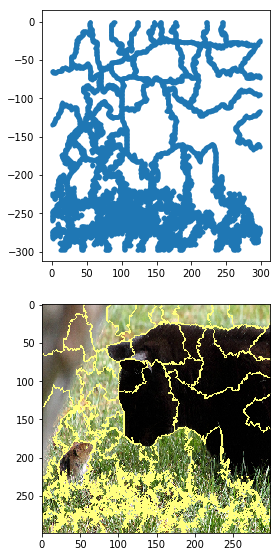

In [15]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(4, 8))
_sp = ax.ravel()[0]
_sp.scatter(y[1], y[0] * -1, marker=".")
c = images[0].copy()
c[outline] = (1, 1, 0)
_ps = ax.ravel()[1]
_ps.imshow(c / 2 + 0.5, cmap=plt.gray())
plt.tight_layout()

Follows same steps as LimeTextExp -- i.e. get neighborhood, train model to be like og model  
Perturb - on/off superpixels  

Image classifiers are a bit slow. Notice that an explanation on my Surface Book dGPU took 1min 29s

### Now let's see the explanation for the top class ( Black Bear)

We can see the top 5 superpixels that are most positive towards the class with the rest of the image hidden

In [12]:
from skimage.segmentation import mark_boundaries
from skimage.segmentation import find_boundaries

Image Segmentation - process of assigning a label to every pixel in an image such that pixels with the same label share certain characteristics

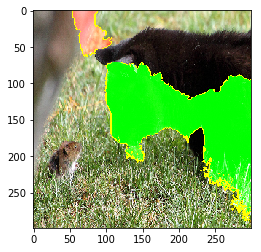

In [18]:
temp, mask = b_explanation.get_image_and_mask(b_explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

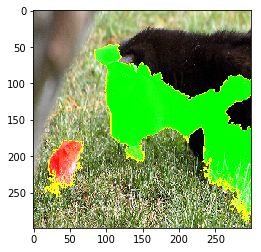

In [19]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Or with the rest of the image present:

We can also see the 'pros and cons' (pros in green, cons in red)

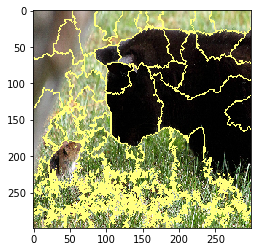

In [59]:
outline = find_boundaries(b_explanation.segments)
c = images[0].copy()
c[outline] = (1, 1, 0)
plt.imshow(c / 2 + 0.5, cmap=plt.gray())

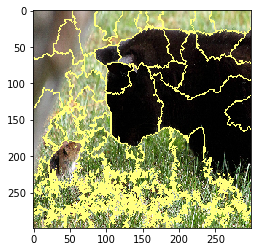

In [61]:
outline = find_boundaries(explanation.segments)
c = images[0].copy()
c[outline] = (1, 1, 0)
plt.imshow(c / 2 + 0.5, cmap=plt.gray())

Or the pros and cons that have weight at least 0.1

# Testing Section!!

jupyter nbconvert --to script [YOUR_NOTEBOOK].ipynb

In [ ]:
import types
from lime.utils.generic_utils import has_arg
from skimage.segmentation import felzenszwalb, slic, quickshift

class BaseWrapper(object):
    """Base class for LIME Scikit-Image wrapper


    Args:
        target_fn: callable function or class instance
        target_params: dict, parameters to pass to the target_fn


    'target_params' takes parameters required to instanciate the
        desired Scikit-Image class/model
    """

    def __init__(self, target_fn=None, **target_params):
        self.target_fn = target_fn
        self.target_params = target_params

        self.target_fn = target_fn
        self.target_params = target_params

    def _check_params(self, parameters):
        """Checks for mistakes in 'parameters'

        Args :
            parameters: dict, parameters to be checked

        Raises :
            ValueError: if any parameter is not a valid argument for the target function
                or the target function is not defined
            TypeError: if argument parameters is not iterable
         """
        a_valid_fn = []
        if self.target_fn is None:
            if callable(self):
                a_valid_fn.append(self.__call__)
            else:
                raise TypeError('invalid argument: tested object is not callable,\
                 please provide a valid target_fn')
        elif isinstance(self.target_fn, types.FunctionType) \
                or isinstance(self.target_fn, types.MethodType):
            a_valid_fn.append(self.target_fn)
        else:
            a_valid_fn.append(self.target_fn.__call__)

        if not isinstance(parameters, str):
            for p in parameters:
                for fn in a_valid_fn:
                    if has_arg(fn, p):
                        pass
                    else:
                        raise ValueError('{} is not a valid parameter'.format(p))
        else:
            raise TypeError('invalid argument: list or dictionnary expected')

    def set_params(self, **params):
        """Sets the parameters of this estimator.
        Args:
            **params: Dictionary of parameter names mapped to their values.

        Raises :
            ValueError: if any parameter is not a valid argument
                for the target function
        """
        self._check_params(params)
        self.target_params = params

    def filter_params(self, fn, override=None):
        """Filters `target_params` and return those in `fn`'s arguments.
        Args:
            fn : arbitrary function
            override: dict, values to override target_params
        Returns:
            result : dict, dictionary containing variables
            in both target_params and fn's arguments.
        """
        override = override or {}
        result = {}
        for name, value in self.target_params.items():
            if has_arg(fn, name):
                result.update({name: value})
        result.update(override)
        return result


class SegmentationAlgorithm(BaseWrapper):
    """ Define the image segmentation function based on Scikit-Image
            implementation and a set of provided parameters

        Args:
            algo_type: string, segmentation algorithm among the following:
                'quickshift', 'slic', 'felzenszwalb'
            target_params: dict, algorithm parameters (valid model paramters
                as define in Scikit-Image documentation)
    """

    def __init__(self, algo_type, **target_params):
        self.algo_type = algo_type
        if (self.algo_type == 'quickshift'):
            BaseWrapper.__init__(self, quickshift, **target_params)
            kwargs = self.filter_params(quickshift)
            self.set_params(**kwargs)
        elif (self.algo_type == 'felzenszwalb'):
            BaseWrapper.__init__(self, felzenszwalb, **target_params)
            kwargs = self.filter_params(felzenszwalb)
            self.set_params(**kwargs)
        elif (self.algo_type == 'slic'):
            BaseWrapper.__init__(self, slic, **target_params)
            kwargs = self.filter_params(slic)
            self.set_params(**kwargs)

    def __call__(self, *args):
            return self.target_fn(args[0], **self.target_params)

In [ ]:
# model_2 = explainer.base.model
# used_features = explanation.top_labels
# seg_fn = SegmentationAlgorithm('quickshift', kernel_size=4, max_dist=200, ratio=0.2, random_seed=explainer.random_seed)
# # Testing: Decreasing influence of superpixel
# # print(model_2.predict(seg_fn(images[0])[:, used_features].reshape(1, -1)))
# gamma = .2700

# prediction = 'American_black_bear'
# while gamma < 1 and prediction == 'American_black_bear':
#     print("\n" + str(gamma))
#     index = np.where(mask != 0)
#     alter_image = transform_img_fn([os.path.join('data','cat_mouse.jpg')])[0]
#     alter_image[index] = alter_image[index] - gamma
#     preds = inet_model.predict(np.array([alter_image]))
#     tup = decode_predictions(preds)[0][0]
#     prediction = tup[1]
#     print("Originial Model:")
#     print(tup)
    
#     lo = np.where(alter_image < 1)
#     alter_image[lo] = -1
#     segments = seg_fn(alter_image)
#     print(segments)
# #     pred = model_2.predict(alter_image[:, used_features].reshape(1, -1))
#     pred = model_2.predict(np.ones((1, 55)).reshape(1, -1))
#     print("Linear Model:")
#     print(pred)
#     print(explanation.local_pred)
#     print(explanation.local_exp.keys())
#     gamma += .001

In [ ]:
# # Loop for cell below:
# # Testing: Decreasing / increasing influence of superpixel
# gamma = 1.00
# prediction = 'American_black_bear'
# while gamma <= 1.5 and prediction == 'American_black_bear':
#     print("\n" + str(gamma))
#     index = np.where(mask != 0)
#     alter_image = transform_img_fn([os.path.join('data','cat_mouse.jpg')])[0]
#     alter_image[index] = alter_image[index] * gamma
#     preds = inet_model.predict(np.array([alter_image]))
#     tup = decode_predictions(preds)[0][0]
#     prediction = tup[1]
#     for x in decode_predictions(preds)[0]:
#         print(x)
#     gamma += .01
    
#     alt = alter_image.copy()
#     alt[np.where(alt > 1)] = 1
#     alt[np.where(alt < -1)] = -1
    
#     ex = lime_image.LimeImageExplainer()
#     expl = ex.explain_instance(alt, inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)
#     print(expl_1.top_labels)
#     temp, mask = expl_1.get_image_and_mask(expl.top_labels, positive_only=False, num_features=10, hide_rest=False)
#     plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
# Testing: Decreasing / increasing influence of superpixel
gamma = 1.00
prediction = 'American_black_bear'
while gamma <= 1.5 and prediction == 'American_black_bear':
    print("\n" + str(gamma))
    index = np.where(mask != 0)
    alter_image = transform_img_fn([os.path.join('data','cat_mouse.jpg')])[0]
    alter_image[index] = alter_image[index] * gamma
    preds = inet_model.predict(np.array([alter_image]))
    tup = decode_predictions(preds)[0][0]
    prediction = tup[1]
    for x in decode_predictions(preds)[0]:
        print(x)
    gamma += .01

alt = alter_image.copy()
alt[np.where(alt > 1)] = 1
alt[np.where(alt < -1)] = -1
plt.imshow(alt / 2 + 0.5)

In [ ]:
ex = lime_image.LimeImageExplainer()
expl = ex.explain_instance(alt, inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

In [ ]:
print(expl.top_labels)
plt.imshow(alt / 2 + 0.5)
# prev top labels:
# [295, 224, 223, 106, 104]

In [ ]:
temp, mask = expl.get_image_and_mask(expl.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
print("Contributing features in perturbed:")

In [ ]:
temp, mask = explanation.get_image_and_mask(295, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
print("Contributing features in original:")

In [ ]:
# # Testing: Decreasing influence of superpixel
# temp, mask = explanation.get_image_and_mask(295, positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)

# gamma = .77
# prediction = 'American_black_bear'
# while gamma <= 1 and prediction == 'American_black_bear':
#     print("\n" + str(gamma))
#     index = np.where(mask != 0)
#     alter_image = transform_img_fn([os.path.join('data','cat_mouse.jpg')])[0]
#     alter_image[index] = alter_image[index] * gamma
#     preds = inet_model.predict(np.array([alter_image]))
#     tup = decode_predictions(preds)[0][0]
#     prediction = tup[1]
#     print(tup)
#     gamma -= .01

In [ ]:
# # Testing: Decreasing influence of all regions other than the superpixel
# gamma = 1.0
# prediction = 'American_black_bear'
# while gamma <= 1 and prediction == 'American_black_bear':
#     print("\n" + str(gamma))
#     index = np.where(mask == 0)
#     alter_image = transform_img_fn([os.path.join('data','cat_mouse.jpg')])[0]
#     alter_image[index] = alter_image[index] * gamma
#     preds = inet_model.predict(np.array([alter_image]))
#     tup = decode_predictions(preds)[0][0]
#     prediction = tup[1]
#     print(tup)
#     gamma -= .01

In [ ]:
# Testing: Adding small shifts to the image, checking corresponding decisions

# Original prediction
alter_image = transform_img_fn([os.path.join('data','cat_mouse.jpg')])[0]
preds = inet_model.predict(np.array([alter_image]))
print("Original Prediction:")
for x in decode_predictions(preds)[0]:
    print(x)
print()

print("Testing Vertical Shifts ...\n")
# Using negative gammas / pixel shifts (downwards is the positive direction)
for gamma in [x for x in range(-1, -19, -1)]:
    print("gamma = " + str(gamma))
    alter_image = transform_img_fn([os.path.join('data','cat_mouse.jpg')])[0]
    alter_image[:gamma] = alter_image[-gamma:]
    alter_image = alter_image[-gamma:]
    preds = inet_model.predict(np.array([alter_image]))
    tup = decode_predictions(preds)[0][0]
    for x in decode_predictions(preds)[0]:
        print(x)
    print()

alt_shift_up = alter_image.copy()
alt_shift_up[np.where(alt_shift_up > 1)] = 1
alt_shift_up[np.where(alt_shift_up < -1)] = -1
plt.imshow(alt_shift_up / 2 + 0.5)

In [ ]:
ex_1 = lime_image.LimeImageExplainer()
expl_1 = ex_1.explain_instance(alt_shift_up, inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

In [ ]:
print(expl_1.top_labels)
plt.imshow(alt_shift_up / 2 + 0.5)
# prev top labels:
# [295, 224, 223, 106, 104]

In [ ]:
temp, mask = expl_1.get_image_and_mask(106, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
print("Contributing features in perturbed:")

In [ ]:
temp, mask = explanation.get_image_and_mask(295, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
print("Contributing features in original:")

In [ ]:
# Testing: Adding small shifts to the image, checking corresponding decisions

# Original prediction
alter_image = transform_img_fn([os.path.join('data','cat_mouse.jpg')])[0]
preds = inet_model.predict(np.array([alter_image]))
print("Original Prediction:")
for x in decode_predictions(preds)[0]:
    print(x)
print()

print("Testing Vertical Shifts ...\n")
# Positive gammas / pixel shifts downwards (downwards is the positive direction)
gamma = 1
prediction = "American_black_bear"
while prediction == "American_black_bear":
    print("gamma = " + str(gamma))
    alter_image = transform_img_fn([os.path.join('data','cat_mouse.jpg')])[0]
    alter_image[gamma:] = alter_image[:-gamma]
    alter_image = alter_image[gamma:]
    preds = inet_model.predict(np.array([alter_image]))
    tup = decode_predictions(preds)[0][0]
    for x in decode_predictions(preds)[0]:
        print(x)
    print()
    prediction = tup[1]
    gamma += 1

In [ ]:
alt_shift_down = alter_image.copy()
alt_shift_down[np.where(alt_shift_down > 1)] = 1
alt_shift_down[np.where(alt_shift_down < -1)] = -1
plt.imshow(alt_shift_down / 2 + 0.5)

In [ ]:
ex_6 = lime_image.LimeImageExplainer()
expl_6 = ex_6.explain_instance(alt_shift_down, inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

In [ ]:
print(expl_6.top_labels)
plt.imshow(alt_shift_down / 2 + 0.5)
# prev top labels:
# [295, 224, 223, 106, 104]

In [ ]:
temp, mask = expl_6.get_image_and_mask(expl_6.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
print("Contributing features in perturbed:")

In [ ]:
temp, mask = explanation.get_image_and_mask(295, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
print("Contributing features in original:")

In [ ]:
# Testing: Adding small shifts to the image, checking corresponding decisions
gamma = -4 # Corresponds to size of pixel shift

# Original prediction
alter_image = transform_img_fn([os.path.join('data','cat_mouse.jpg')])[0]
preds = inet_model.predict(np.array([alter_image]))
print("Original Prediction:")
for x in decode_predictions(preds)[0]:
    print(x)
print()

print("Testing Horizontal Shifts ...\n")
# With negative gammas
gamma = -1
prediction = "American_black_bear"
while prediction == "American_black_bear":
    print("gamma = " + str(gamma))
    alter_image = transform_img_fn([os.path.join('data','cat_mouse.jpg')])[0]
    alter_image[:, :gamma] = alter_image[:, -gamma:]
    alter_image = alter_image[:, -gamma:]
    preds = inet_model.predict(np.array([alter_image]))
    tup = decode_predictions(preds)[0][0]
    prediction = tup[1]
    for x in decode_predictions(preds)[0]:
        print(x)
    print()
    gamma -= 1

In [ ]:
alt_shift_up = alter_image.copy()
alt_shift_up[np.where(alt_shift_up > 1)] = 1
alt_shift_up[np.where(alt_shift_up < -1)] = -1
plt.imshow(alt_shift_up / 2 + 0.5)

In [ ]:
ex_7 = lime_image.LimeImageExplainer()
expl_7 = ex_7.explain_instance(alt_shift_up, inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

In [ ]:
print(expl_7.top_labels)
plt.imshow(alt_shift_up / 2 + 0.5)
# prev top labels:
# [295, 224, 223, 106, 104]

In [ ]:
temp, mask = expl_7.get_image_and_mask(expl_7.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
print("Contributing features in perturbed:")

In [ ]:
temp, mask = explanation.get_image_and_mask(295, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
print("Contributing features in original:")

In [ ]:
# Original prediction
alter_image = transform_img_fn([os.path.join('data','cat_mouse.jpg')])[0]
preds = inet_model.predict(np.array([alter_image]))
print("Original Prediction:")
for x in decode_predictions(preds)[0]:
    print(x)
print()

print("Testing Horizontal Shifts ...\n")
# With positive gammas
gamma = 1
result = "American_black_bear"
while result == "American_black_bear":
    print("gamma = " + str(gamma))
    alter_image = transform_img_fn([os.path.join('data','cat_mouse.jpg')])[0]
    alter_image[:, gamma:] = alter_image[:, :-gamma]
    alter_image = alter_image[:, gamma:]
    preds = inet_model.predict(np.array([alter_image]))
    tup = decode_predictions(preds)[0][0]
    result = tup[1]
    gamma += 1
    for x in decode_predictions(preds)[0]:
        print(x)
    print()

In [ ]:
alt_shift_left = alter_image.copy()
alt_shift_left[np.where(alt_shift_left > 1)] = 1
alt_shift_left[np.where(alt_shift_left < -1)] = -1
plt.imshow(alt_shift_left / 2 + 0.5)

In [ ]:
ex_2 = lime_image.LimeImageExplainer()
expl_2 = ex_2.explain_instance(alt_shift_left, inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

In [ ]:
print(expl_2.top_labels)
plt.imshow(alt_shift_left / 2 + 0.5)
# prev top labels:
# [295, 224, 223, 106, 104]

In [ ]:
temp, mask = expl_2.get_image_and_mask(expl_2.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
print("Contributing features in perturbed:")

In [ ]:
temp, mask = explanation.get_image_and_mask(295, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
print("Contributing features in original:")

In [ ]:
# Testing: Rotations

# Original prediction
alter_image = transform_img_fn([os.path.join('data','cat_mouse.jpg')])[0]
preds = inet_model.predict(np.array([alter_image]))
print("Original Prediction:")
for x in decode_predictions(preds)[0]:
    print(x)
print()

print("Testing 90 Degree Rotations ...\n")
for i in range(1, 3):
    print("Rotated: " + str(i * 90) + " degrees counterclockwise")
    alter_image = np.rot90(alter_image)
    preds = inet_model.predict(np.array([alter_image]))
    preds = inet_model.predict(np.array([alter_image]))
    tup = decode_predictions(preds)[0][0]
    for x in decode_predictions(preds)[0]:
        print(x)
    print()

In [ ]:
alt_rot_180 = alter_image.copy()
alt_rot_180[np.where(alt_rot_180 > 1)] = 1
alt_rot_180[np.where(alt_rot_180 < -1)] = -1
plt.imshow(alt_rot_180 / 2 + 0.5)

In [ ]:
ex_3 = lime_image.LimeImageExplainer()
expl_3 = ex_3.explain_instance(alt_rot_180, inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

In [ ]:
print(expl_3.top_labels)
plt.imshow(alt_rot_180 / 2 + 0.5)
# prev top labels:
# [295, 224, 223, 106, 104]

In [ ]:
temp, mask = expl_3.get_image_and_mask(102, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
print("Contributing features in perturbed:")

In [ ]:
temp, mask = explanation.get_image_and_mask(295, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
print("Contributing features in original:")

In [ ]:
# Testing: Rotations

# Original prediction
alter_image = transform_img_fn([os.path.join('data','cat_mouse.jpg')])[0]
preds = inet_model.predict(np.array([alter_image]))
print("Original Prediction:")
for x in decode_predictions(preds)[0]:
    print(x)
print()

print("Testing 90 Degree Rotations ...\n")
for i in range(1, 4):
    print("Rotated: " + str(i * 90) + " degrees counterclockwise")
    alter_image = np.rot90(alter_image)
    preds = inet_model.predict(np.array([alter_image]))
    preds = inet_model.predict(np.array([alter_image]))
    tup = decode_predictions(preds)[0][0]
    for x in decode_predictions(preds)[0]:
        print(x)
    print()

In [ ]:
alt_rot_270 = alter_image.copy()
alt_rot_270[np.where(alt_rot_270 > 1)] = 1
alt_rot_270[np.where(alt_rot_270 < -1)] = -1
plt.imshow(alt_rot_270 / 2 + 0.5)

In [ ]:
ex_4 = lime_image.LimeImageExplainer()
expl_4 = ex_4.explain_instance(alt_rot_270, inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

In [ ]:
print(expl_4.top_labels)
plt.imshow(alt_rot_270 / 2 + 0.5)
# prev top labels:
# [295, 224, 223, 106, 104]

In [ ]:
temp, mask = expl_4.get_image_and_mask(223, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
print("Contributing features in perturbed:")

In [ ]:
temp, mask = explanation.get_image_and_mask(295, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
print("Contributing features in original:")

In [ ]:
# Testing: Zoom

# Original prediction
alter_image = transform_img_fn([os.path.join('data','cat_mouse.jpg')])[0]
preds = inet_model.predict(np.array([alter_image]))
print("Original Prediction:")
for x in decode_predictions(preds)[0]:
    print(x)
print()

print("Testing Zoom In ...\n")
# zoom should be < (299/2)
zoom, result = 1, "American_black_bear"
while zoom < 299 / 2 and result == "American_black_bear":
    print("zoom = " + str(zoom))
    zoomed = alter_image[zoom:-zoom, zoom:-zoom]
    preds = inet_model.predict(np.array([zoomed]))
    preds = inet_model.predict(np.array([zoomed]))
    tup = decode_predictions(preds)[0][0]
    result = tup[1]
    for x in decode_predictions(preds)[0]:
        print(x)
    print()
    zoom += 1

In [ ]:
alt_zoom = alter_image.copy()
alt_zoom[np.where(alt_zoom > 1)] = 1
alt_zoom[np.where(alt_zoom < -1)] = -1
plt.imshow(alt_zoom / 2 + 0.5)

In [ ]:
ex_5 = lime_image.LimeImageExplainer()
expl_5 = ex_5.explain_instance(alt_zoom, inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

In [ ]:
print(expl_5.top_labels)
plt.imshow(alt_zoom / 2 + 0.5)
# prev top labels:
# [295, 224, 223, 106, 104]

In [ ]:
temp, mask = expl_5.get_image_and_mask(295, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
print("Contributing features in perturbed:")

In [ ]:
temp, mask = explanation.get_image_and_mask(295, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
print("Contributing features in original:")

### Let's see the explanation for Wombat

Most positive towards wombat:

In [ ]:
temp, mask = explanation.get_image_and_mask(106, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Pros and cons:

In [ ]:
temp, mask = explanation.get_image_and_mask(106, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
